## Expected SARSA Algorithm

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)

Expected SARSA is a mixture of Q-learning and SARSA. The difference is that $max$ is replaced by an expectation in the Q-learning update rule. 

Update rule for Q-learning:

$$\displaystyle Q(S_t, A_t) \; = \; Q(S_t, A_t) \, + \, \alpha [R_{t+1} + \gamma \, max_{A_{t+1}} Q(S_{t+1}, A_{t+1}) \, - \, Q(S_t, A_t)]$$

Update rule for Expected SARSA:

\begin{align*}
Q(S_t, A_t) \; & = \; Q(S_t, A_t) \, + \, \alpha \left[ R_{t+1} \, + \, \gamma \cdot \mathbb{E}_a \, \left[ Q(S_{t+1}, a) \right] \, - \, Q(S_t, A_t) \right] \\
& = \; Q(S_t, A_t) \, + \, \alpha \left[ R_{t+1} \, + \, \gamma \cdot \sum \limits_a \left[ \pi (a | S_{t+1}) \, \cdot \, Q(S_{t+1}, a) \right] \, - \, Q(S_t, A_t) \right] \\
& = \; Q(S_t, A_t) \, + \, \alpha \cdot \delta_t
\end{align*}

, where 
- $\displaystyle \; \delta_t \; = \; R_{t+1} + \gamma \cdot \mathbb{E}_a \, \left[ Q(S_{t+1}, a) \right] \, - \, Q(S_t, A_t) \; = \;$ TD error 
- $\displaystyle \mathbb{E}_a \, \left[ Q(S_{t+1}, a) \right] = \sum \limits_a \left[ \pi (a | S_{t+1}) \, \cdot \, Q(S_{t+1}, a) \right] $

- We can run expected SARSA as on-policy, which is what we will do while testing it against the cliff and taxi worlds. 
- It can also be run off-­policy where the behavior policy is more exploratory and the target policy $\pi$ follows a deterministic greedy policy.

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [2]:
class Expected_SARSA:
    """Expected_SARSA (on-policy TD control) algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_Q(self, state, action):
        return self._Q[state][action]


    def set_Q(self, state, action, value):
        self._Q[state][action] = value


    def update(self, state, action, reward, next_state, done):
        """
        This is the main update function for the Expected SARSA algorithm.
        Note that this function only contains the update equations, 
        not the entire Expected SARSA algorithm.
        """
        if not done:
            best_next_action = self.max_action(next_state)
            actions = self.get_possible_actions(next_state)
            next_q = 0
            # calculate the expected value of the next state
            for next_action in actions:
                if next_action == best_next_action:
                    term = 1 - self.epsilon + (self.epsilon / len(actions))
                else:
                    term = self.epsilon / len(actions)
                next_q += term * self._get_Q(next_state, next_action)
            td_error = reward + self.gamma * next_q - self._get_Q(state, action)
        else:
            td_error = reward - self._get_Q(state, action)
        q_value = self._get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, q_value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state-action pair that has the highest Q-value.
        If there are multiple actions with the same Q-value,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self._get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [3]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [5]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: Expected_SARSA object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(t_max):
            next_state, reward, done, trunc, _ = env.step(action)
            next_action = agent.get_action(next_state)
            flag = (done or trunc)
            agent.update(state, action, reward, next_state, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)


In [6]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out Q-learning on Cliff Walking environment

In [ ]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [7]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [8]:
cw_env.reset()

(36, {'prob': 1})

In [9]:
cw_env.action_space.n

4

In [10]:
cw_env.observation_space.n

48

In [11]:
agent1 = Expected_SARSA(
    get_possible_actions = lambda s : range(cw_env.action_space.n),
    strategy = epsilon_greedy_strategy,
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(cw_env, agent1, num_episodes=5000, decay_rate=0.99)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:15<00:00, 324.19it/s]


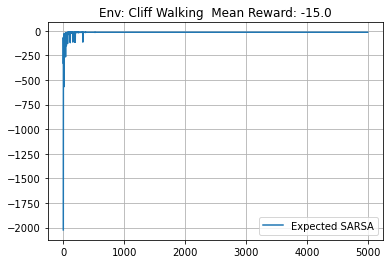

In [12]:
plot_rewards("Cliff Walking", rewards, "Expected SARSA")

In [13]:
def fn():
    action_dict = {
        0: "UP",
        1: "RIGHT",
        2: "DOWN",
        3: "LEFT"
    }
    state, _ = cw_env.reset()
    print(f"state: {state}")
    while True:
        best_action = agent1.max_action(state)
        print(f"best_action: {action_dict[best_action]}")
        next_state, reward, done, trunc, _ = cw_env.step(best_action)
        if done or trunc:
            print(f"Terminal state reached.\nState: {next_state}")
            break
        state = next_state
        print(f"state: {state}")

fn()

state: 36
best_action: UP
state: 24
best_action: UP
state: 12
best_action: RIGHT
state: 13
best_action: RIGHT
state: 14
best_action: RIGHT
state: 15
best_action: RIGHT
state: 16
best_action: RIGHT
state: 17
best_action: RIGHT
state: 18
best_action: RIGHT
state: 19
best_action: RIGHT
state: 20
best_action: RIGHT
state: 21
best_action: RIGHT
state: 22
best_action: RIGHT
state: 23
best_action: DOWN
state: 35
best_action: DOWN
Terminal state reached.
State: 47


### Trying out Q-learning on Taxi environment

In [ ]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [14]:
t_env = gym.make("Taxi-v3")

In [15]:
t_env.reset()

(402, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})

In [16]:
t_env.action_space.n

6

In [17]:
t_env.observation_space.n

500

In [18]:
agent2 = Expected_SARSA(
    get_possible_actions = lambda state: range(t_env.action_space.n),
    strategy = epsilon_greedy_strategy, 
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(t_env, agent2, num_episodes=5000, decay_rate=0.99)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:21<00:00, 235.98it/s]


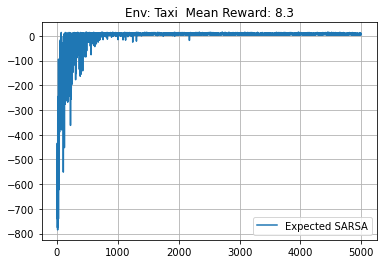

In [19]:
plot_rewards("Taxi", rewards, "Expected SARSA")